# Import

In [27]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Import data

In [2]:
dossier_csv = 'data/'

fichiers_csv = glob.glob(dossier_csv + '*.csv')

dataframes = []

for fichier in fichiers_csv:
    try:
        df = pd.read_csv(fichier, on_bad_lines='skip')
        dataframes.append(df)
    except pd.errors.ParserError as e:
        print(f"Erreur lors de la lecture du fichier {fichier}: {e}")

colonnes = set()
for df in dataframes:
    colonnes.update(df.columns)

dataframes = [df.reindex(columns=colonnes) for df in dataframes]

df_concatene = pd.concat(dataframes, ignore_index=True)

print(df_concatene)

/var/folders/rt/0hb6rtq14291d__lx9m1jbd00000gn/T/ipykernel_43737/1115661823.py:9: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fichier, on_bad_lines='skip')
/var/folders/rt/0hb6rtq14291d__lx9m1jbd00000gn/T/ipykernel_43737/1115661823.py:9: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fichier, on_bad_lines='skip')
/var/folders/rt/0hb6rtq14291d__lx9m1jbd00000gn/T/ipykernel_43737/1115661823.py:9: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fichier, on_bad_lines='skip')
/var/folders/rt/0hb6rtq14291d__lx9m1jbd00000gn/T/ipykernel_43737/1115661823.py:9: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fichier, on_bad_lines='skip')
/var/folders/rt/0hb6rtq14291d__lx9m1jbd00000gn/T/ipykernel_43737/1115661

         MONTH DEST_STATE_NM  TAXI_IN  FIRST_DEP_TIME  ARR_DELAY  \
0            9      New York      5.0             NaN      -23.0   
1            9      New York      7.0             NaN       -6.0   
2            9      New York      8.0             NaN      -19.0   
3            9      New York      6.0             NaN      -27.0   
4            9      New York      5.0             NaN      -21.0   
...        ...           ...      ...             ...        ...   
5635973      2    California     10.0             NaN      -11.0   
5635974      2      Illinois      4.0             NaN       -6.0   
5635975      2    California      3.0             NaN      -17.0   
5635976      2    California      2.0             NaN       -9.0   
5635977      2    California      5.0             NaN       -9.0   

          DEST_CITY_NAME  CRS_ELAPSED_TIME  DISTANCE  WHEELS_OFF ORIGIN  ...  \
0           New York, NY              75.0     187.0       604.0    BOS  ...   
1           New York, N

# EDA + Nettoyage

In [7]:
# Colonnes à retirer
colonnes_a_retirer = [
    'QUARTER', 'FL_DATE', 'AIRLINE_ID', 'CARRIER', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID',
    'ORIGIN_CITY_MARKET_ID', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
    'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID',
    'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC', 'DEP_DELAY_NEW',
    'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'WHEELS_OFF', 'WHEELS_ON', 'ARR_DELAY_NEW',
    'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'FLIGHTS', 'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME',
    'LONGEST_ADD_GTIME'
]

# Supprimer les colonnes spécifiées
df_concatene = df_concatene.drop(columns=colonnes_a_retirer, errors='ignore')

# Afficher les colonnes disponibles après suppression
print("Colonnes disponibles après suppression :")
print(df_concatene.columns)


Colonnes disponibles après suppression :
Index(['MONTH', 'TAXI_IN', 'ARR_DELAY', 'CRS_ELAPSED_TIME', 'DISTANCE',
       'ORIGIN', 'LATE_AIRCRAFT_DELAY', 'CANCELLATION_CODE', 'DAY_OF_WEEK',
       'Unnamed: 64', 'TAXI_OUT', 'ARR_TIME', 'UNIQUE_CARRIER', 'DIVERTED',
       'TAIL_NUM', 'DEP_TIME', 'AIR_TIME', 'CRS_DEP_TIME', 'DISTANCE_GROUP',
       'SECURITY_DELAY', 'DEST', 'CRS_ARR_TIME', 'CANCELLED', 'CARRIER_DELAY',
       'FL_NUM', 'DAY_OF_MONTH', 'YEAR', 'ACTUAL_ELAPSED_TIME', 'DEP_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY'],
      dtype='object')


## Valeurs manquantes

In [8]:
missing_values_percentage = df_concatene.isnull().mean() * 100
high_missing_cols = missing_values_percentage[missing_values_percentage > 50]
df_cleaned = df_concatene.drop(columns=high_missing_cols.index)

## Valeurs nulles

In [9]:
df_cleaned = df_cleaned.dropna()

## Conversion date

In [10]:
if 'FL_DATE' in df_cleaned.columns:
    df_cleaned['FL_DATE'] = pd.to_datetime(df_cleaned['FL_DATE'], errors='coerce')

## Valeurs aberrantes

In [11]:
def remove_outliers(df, column):
    df['z_score'] = zscore(df[column])
    df_filtered = df[(df['z_score'] > -3) & (df['z_score'] < 3)]
    df_filtered = df_filtered.drop(columns=['z_score'])
    return df_filtered

if 'ARR_DELAY' in df_cleaned.columns:
    df_cleaned = remove_outliers(df_cleaned, 'ARR_DELAY')

In [12]:
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5455550 entries, 0 to 5635977
Data columns (total 24 columns):
 #   Column               Dtype  
---  ------               -----  
 0   MONTH                int64  
 1   TAXI_IN              float64
 2   ARR_DELAY            float64
 3   CRS_ELAPSED_TIME     float64
 4   DISTANCE             float64
 5   ORIGIN               object 
 6   DAY_OF_WEEK          object 
 7   TAXI_OUT             object 
 8   ARR_TIME             object 
 9   UNIQUE_CARRIER       object 
 10  DIVERTED             float64
 11  TAIL_NUM             object 
 12  DEP_TIME             object 
 13  AIR_TIME             float64
 14  CRS_DEP_TIME         float64
 15  DISTANCE_GROUP       float64
 16  DEST                 object 
 17  CRS_ARR_TIME         float64
 18  CANCELLED            float64
 19  FL_NUM               object 
 20  DAY_OF_MONTH         object 
 21  YEAR                 object 
 22  ACTUAL_ELAPSED_TIME  float64
 23  DEP_DELAY            float64
dty

In [13]:
df_cleaned.to_csv('data_cleaned.csv', index=False)

# 1. Statistiques descriptives

In [14]:
print("Statistiques descriptives :")
print(df_cleaned.describe(include='all'))

Statistiques descriptives :
               MONTH       TAXI_IN     ARR_DELAY  CRS_ELAPSED_TIME  \
count   5.455550e+06  5.455550e+06  5.455550e+06      5.455550e+06   
unique           NaN           NaN           NaN               NaN   
top              NaN           NaN           NaN               NaN   
freq             NaN           NaN           NaN               NaN   
mean    6.513491e+00  7.403373e+00 -4.548946e-01      1.452731e+02   
std     3.416190e+00  5.471853e+00  2.441945e+01      7.637453e+01   
min     1.000000e+00  1.000000e+00 -1.190000e+02      1.800000e+01   
25%     3.000000e+00  4.000000e+00 -1.400000e+01      8.800000e+01   
50%     7.000000e+00  6.000000e+00 -6.000000e+00      1.260000e+02   
75%     9.000000e+00  9.000000e+00  5.000000e+00      1.780000e+02   
max     1.200000e+01  1.520000e+02  1.290000e+02      7.050000e+02   

            DISTANCE   ORIGIN  DAY_OF_WEEK   TAXI_OUT   ARR_TIME  \
count   5.455550e+06  5455550    5455550.0  5455550.0  5455550.

# 2. Distribution des retards à l'arrivée


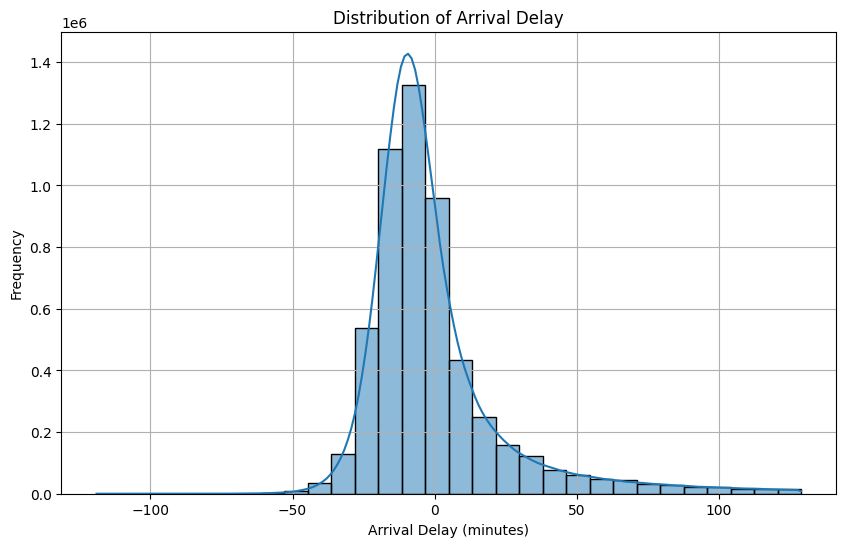

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['ARR_DELAY'], bins=30, kde=True)
plt.title('Distribution of Arrival Delay')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. Matrice de corrélation

/var/folders/rt/0hb6rtq14291d__lx9m1jbd00000gn/T/ipykernel_43737/3471309152.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_cleaned.corr()
/Users/guillaumedemerges/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


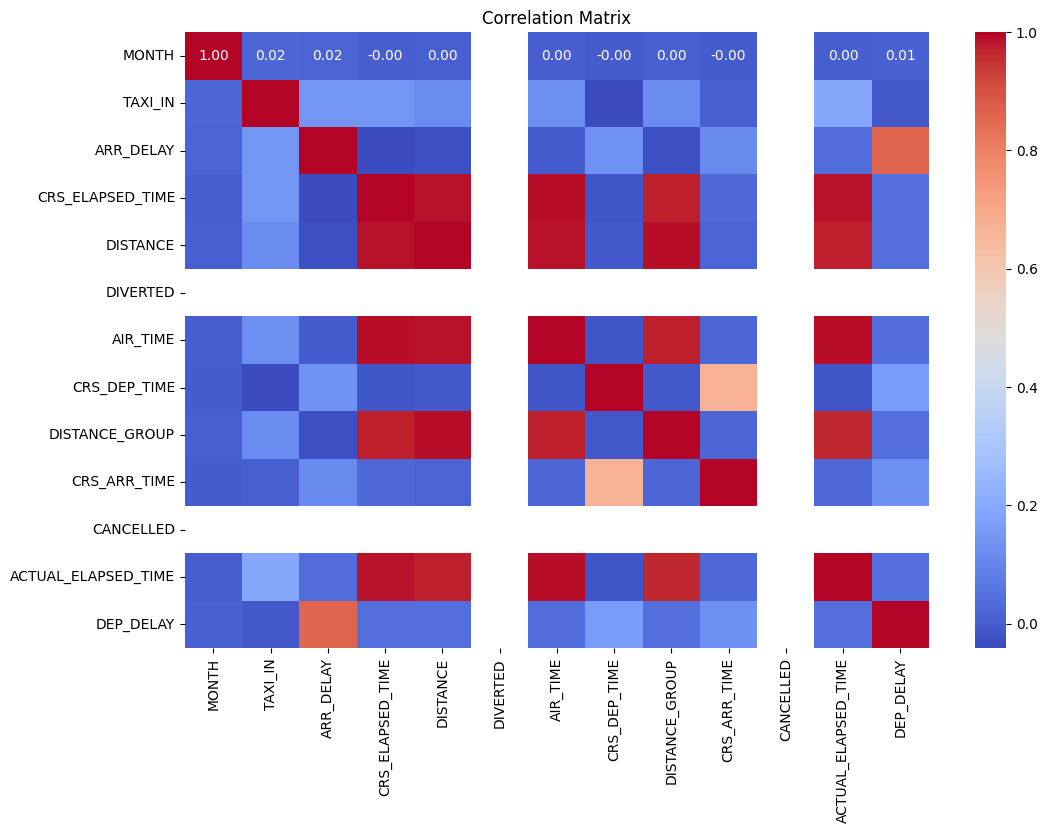

In [16]:
plt.figure(figsize=(12, 8))
correlation_matrix = df_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# 4. Boxplot des retards par mois


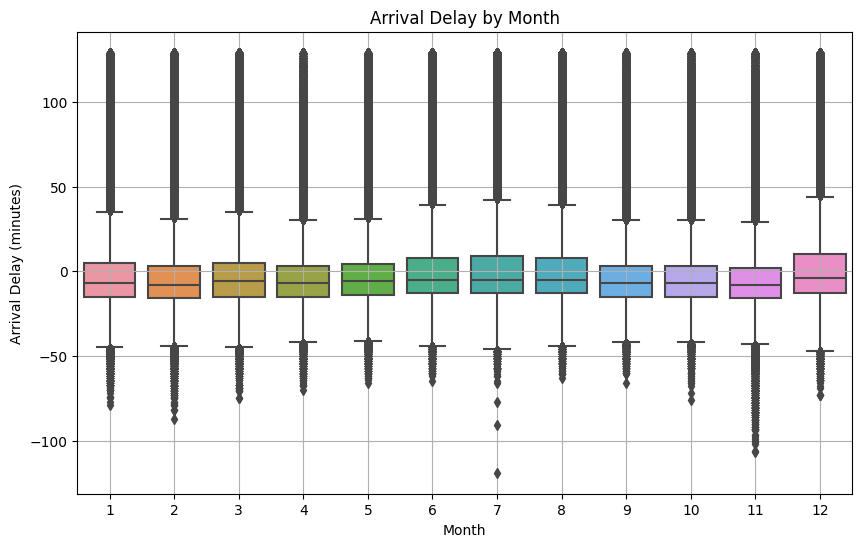

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='MONTH', y='ARR_DELAY', data=df_cleaned)
plt.title('Arrival Delay by Month')
plt.xlabel('Month')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True)
plt.show()

# 5. Boxplot des retards par jour de la semaine

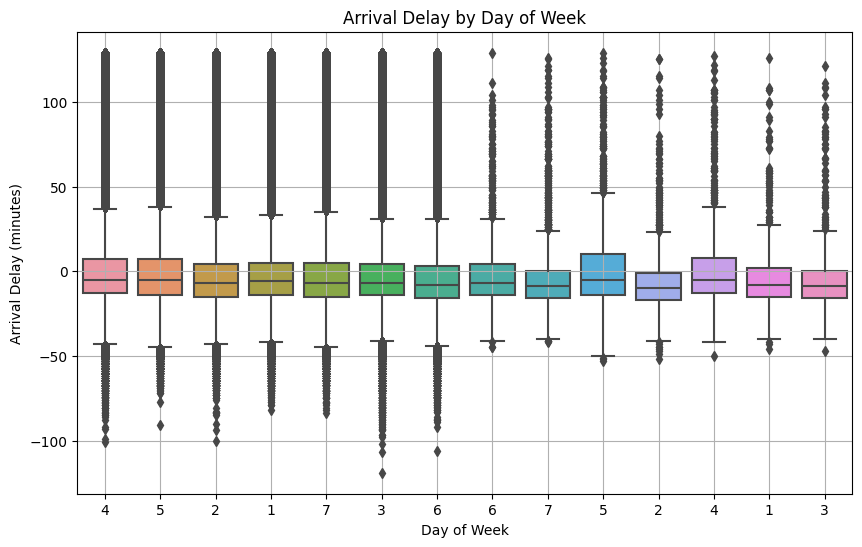

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='DAY_OF_WEEK', y='ARR_DELAY', data=df_cleaned)
plt.title('Arrival Delay by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True)
plt.show()

# 6. Moyenne des retards par compagnie aérienne

In [20]:
if 'CARRIER' in df_cleaned.columns:
    carrier_delay_mean = df_cleaned.groupby('CARRIER')['ARR_DELAY'].mean().sort_values()
    plt.figure(figsize=(12, 6))
    carrier_delay_mean.plot(kind='bar')
    plt.title('Average Arrival Delay by Carrier')
    plt.xlabel('Carrier')
    plt.ylabel('Average Arrival Delay (minutes)')
    plt.grid(True)
    plt.show()

# 7. Moyenne des retards par mois

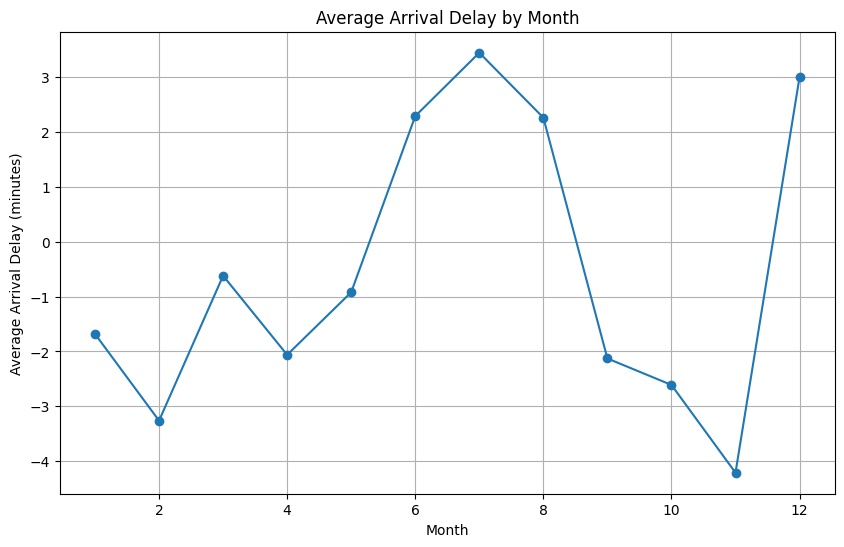

In [21]:
if 'MONTH' in df_cleaned.columns:
    monthly_delay_mean = df_cleaned.groupby('MONTH')['ARR_DELAY'].mean()
    plt.figure(figsize=(10, 6))
    monthly_delay_mean.plot(kind='line', marker='o')
    plt.title('Average Arrival Delay by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Arrival Delay (minutes)')
    plt.grid(True)
    plt.show()

# 8. Analyse des retards par aéroport d'origine


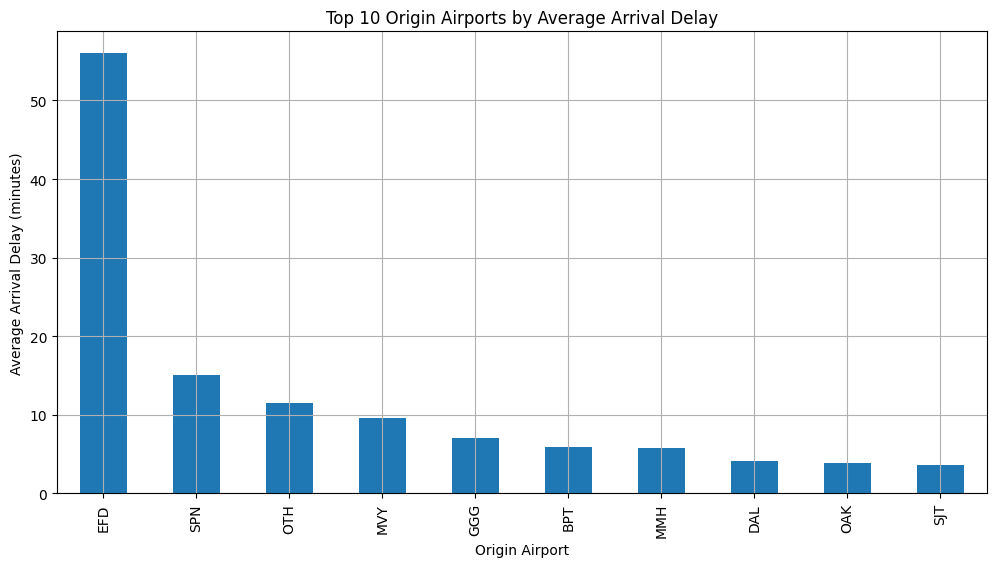

In [22]:
plt.figure(figsize=(12, 6))
origin_delay_mean = df_cleaned.groupby('ORIGIN')['ARR_DELAY'].mean().sort_values(ascending=False).head(10)
origin_delay_mean.plot(kind='bar')
plt.title('Top 10 Origin Airports by Average Arrival Delay')
plt.xlabel('Origin Airport')
plt.ylabel('Average Arrival Delay (minutes)')
plt.grid(True)
plt.show()

# 9. Analyse des retards par aéroport de destination

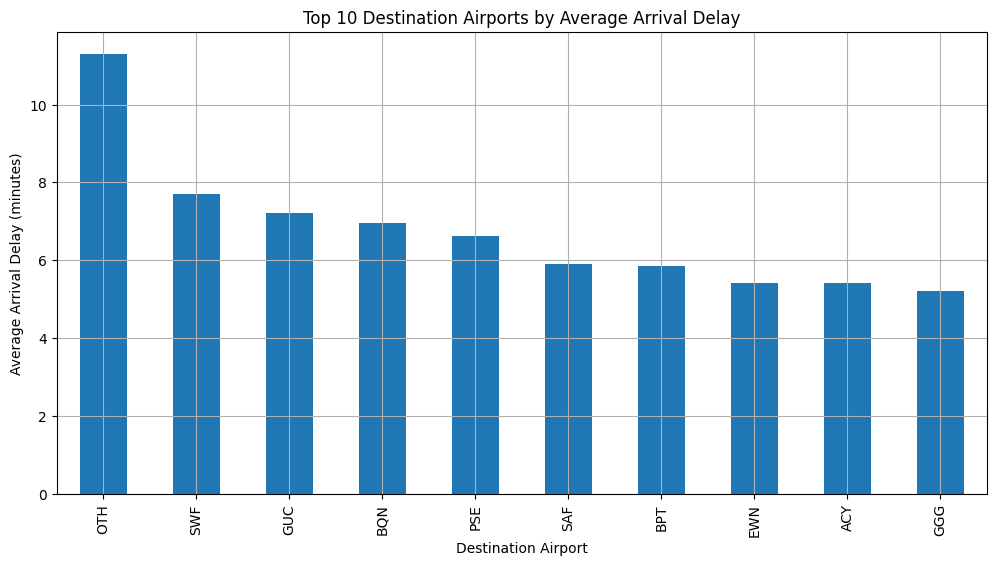

In [23]:
plt.figure(figsize=(12, 6))
dest_delay_mean = df_cleaned.groupby('DEST')['ARR_DELAY'].mean().sort_values(ascending=False).head(10)
dest_delay_mean.plot(kind='bar')
plt.title('Top 10 Destination Airports by Average Arrival Delay')
plt.xlabel('Destination Airport')
plt.ylabel('Average Arrival Delay (minutes)')
plt.grid(True)
plt.show()

# 10. Analyse des retards par période de la journée

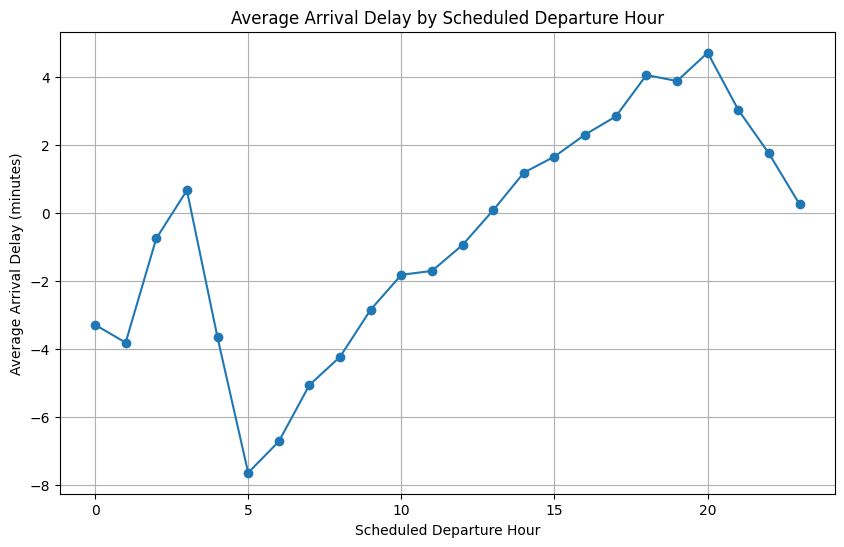

In [24]:
plt.figure(figsize=(10, 6))
df_cleaned['CRS_DEP_HOUR'] = df_cleaned['CRS_DEP_TIME'] // 100
hourly_delay_mean = df_cleaned.groupby('CRS_DEP_HOUR')['ARR_DELAY'].mean()
hourly_delay_mean.plot(kind='line', marker='o')
plt.title('Average Arrival Delay by Scheduled Departure Hour')
plt.xlabel('Scheduled Departure Hour')
plt.ylabel('Average Arrival Delay (minutes)')
plt.grid(True)
plt.show()

# 11. Analyse des retards par type d'avion (TAIL_NUM)


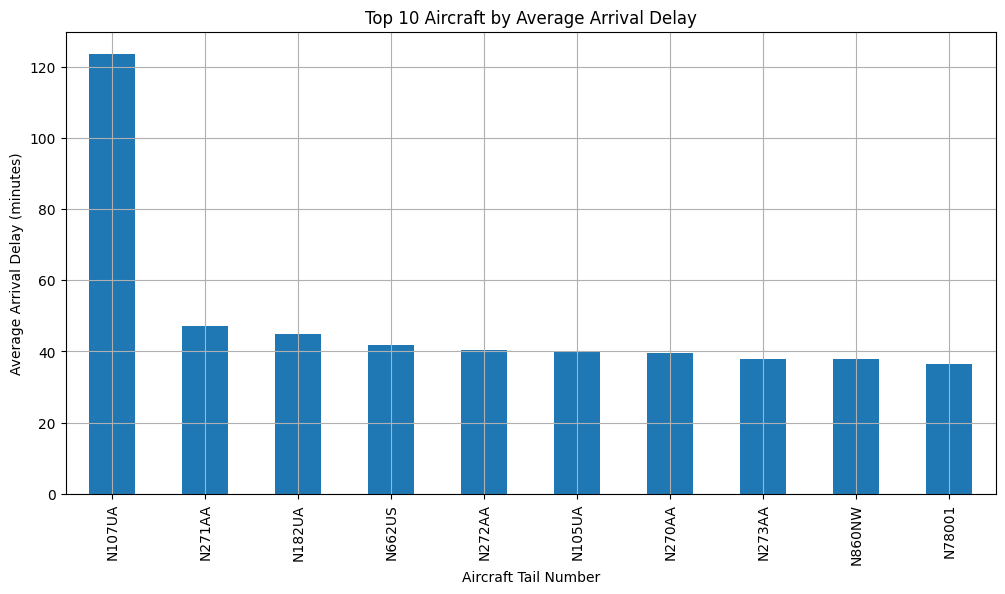

In [25]:
plt.figure(figsize=(12, 6))
tail_num_delay_mean = df_cleaned.groupby('TAIL_NUM')['ARR_DELAY'].mean().sort_values(ascending=False).head(10)
tail_num_delay_mean.plot(kind='bar')
plt.title('Top 10 Aircraft by Average Arrival Delay')
plt.xlabel('Aircraft Tail Number')
plt.ylabel('Average Arrival Delay (minutes)')
plt.grid(True)
plt.show()

# 12. Analyse des retards en fonction de la distance des vols

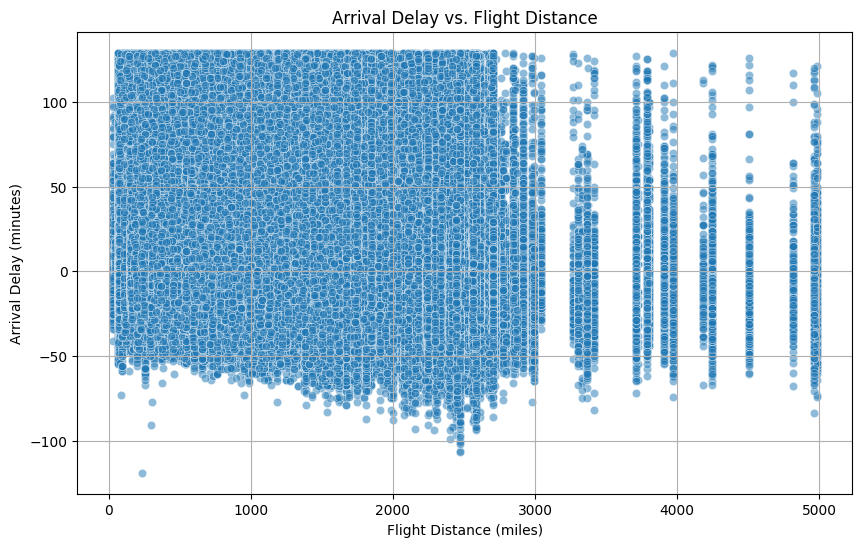

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DISTANCE', y='ARR_DELAY', data=df_cleaned, alpha=0.5)
plt.title('Arrival Delay vs. Flight Distance')
plt.xlabel('Flight Distance (miles)')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True)
plt.show()